Introduction
----------------
Self-organizing maps are computationally intensive to train, especially if the original space is high-dimensional or the map is large. Very large maps where the number of neurons is at least five times the number of data points are sometimes called emergent-self organizing maps -- these are especially demanding to train. [Somoclu](http://peterwittek.github.io/somoclu/) is a highly efficient, parallel and distributed algorithm to train such maps, and its Python interface was recently updated. This enables fast training of self-organizing maps on multicore CPUs or a GPU from Python, albeit only on dense data, and the distributed computing capability is also not exposed. The Python interface also lets you process the output files of the command-line version, so if the data is sparse or the map was trained on a cluster, you can still use the module for visualization. Here we take a quick look at how to train and visualize a small map.

First, we import the necessary modules:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import somoclu
%matplotlib inline  

Then we generate and plot some random data in three categories:

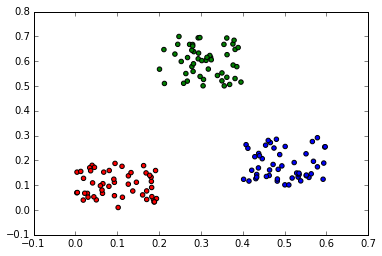

In [22]:
c1 = np.random.rand(50, 2)/5
c2 = (0.2, 0.5) + np.random.rand(50, 2)/5
c3 = (0.4, 0.1) + np.random.rand(50, 2)/5
data = np.float32(np.concatenate((c1, c2, c3)))
colors = [ "red" ] * 50
colors.extend(["green"] * 50)
colors.extend(["blue"] * 50)
plt.scatter(data[:,0], data[:,1], c=colors)
labels = range(150)

Planar maps
---------------
We train Somoclu with default parameter settings, asking for a large map that qualifies as an emergent self-organizing map for this data:

In [23]:
n_columns, n_rows = 160, 100
som = somoclu.Somoclu(n_columns, n_rows, data=data)
%time som.train()

CPU times: user 6.14 s, sys: 20 ms, total: 6.16 s
Wall time: 4.38 s


We plot the component planes of the trained codebook of the ESOM:

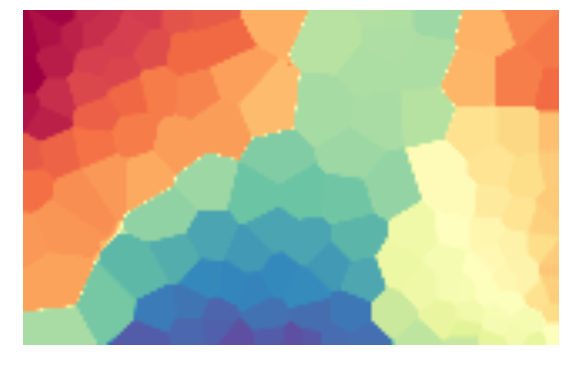

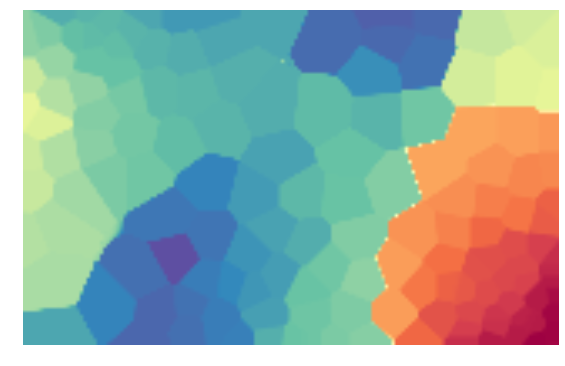

In [24]:
som.view_component_planes()

Finally we plot the U-Matrix, together with the best matching units for each data point. We color code the units with the classes of the data points and also add the labels of the data points.

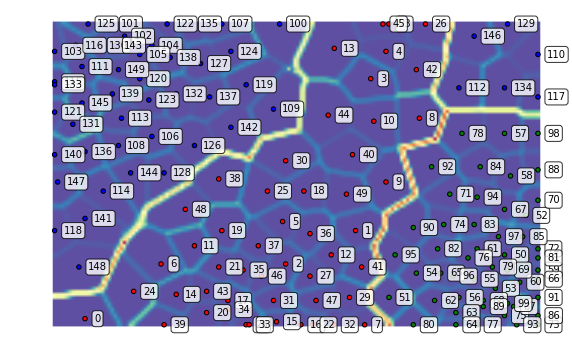

In [25]:
som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels)

Toroid topology, hexagonal grid
-----------------------------------------
We can repeat the above with a toroid topology by specifying the map type as follows:

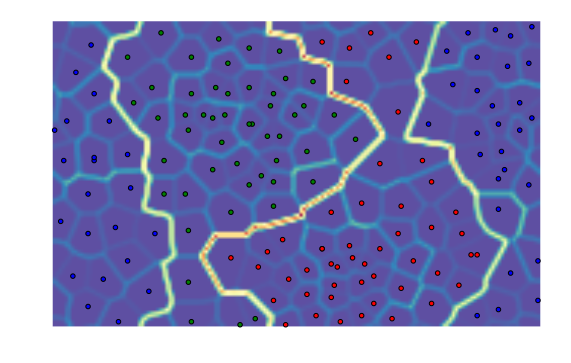

In [26]:
som = somoclu.Somoclu(n_columns, n_rows, data=data, maptype="toroid")
som.train()
som.view_umatrix(bestmatches=True, bestmatchcolors=colors)

Notice how the edges of the map connect to the other side. Hexagonal neurons are also implemented:

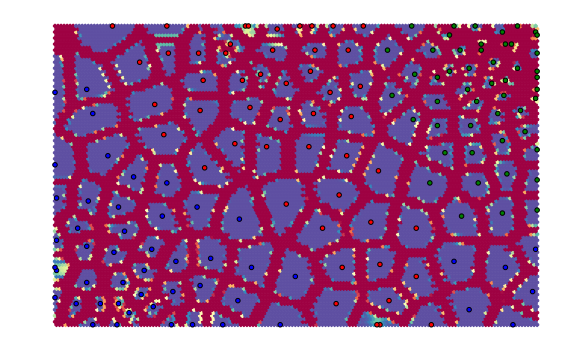

In [27]:
som = somoclu.Somoclu(n_columns, n_rows, data=data, gridtype="hexagonal")
som.train()
som.view_umatrix(bestmatches=True, bestmatchcolors=colors)

The separation of the individual points is more marked with these neurons.

Evolving maps
------------------
One of the great advantages of self-organizing maps is that they are incremental, they can be updated with new data. This is especially interesting if the data points retain their old label, that is, the properties of the vectors change in the high-dimensional space. Let us train again a toroid rectangular emergent map on the same data:

In [28]:
som = somoclu.Somoclu(n_columns, n_rows, data=data, maptype="toroid")
som.train()

Next, let us assume that the green cluster moves to the left, the other points remaining invariant:

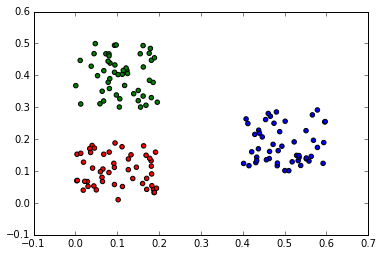

In [29]:
c2_shifted = c2 - 0.2
updated_data = np.float32(np.concatenate((c1, c2_shifted, c3)))
plt.scatter(updated_data[:,0], updated_data[:,1], c=colors)

We can update the map to reflect this shift. We plot the map before and after continuing the training:

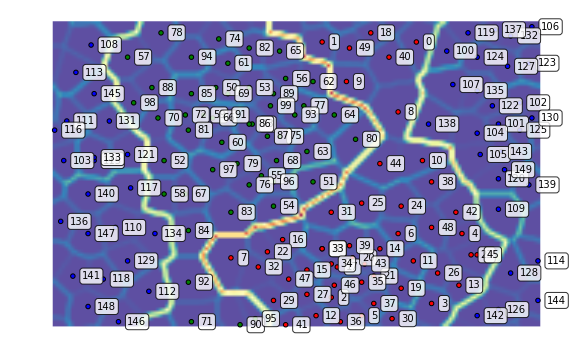

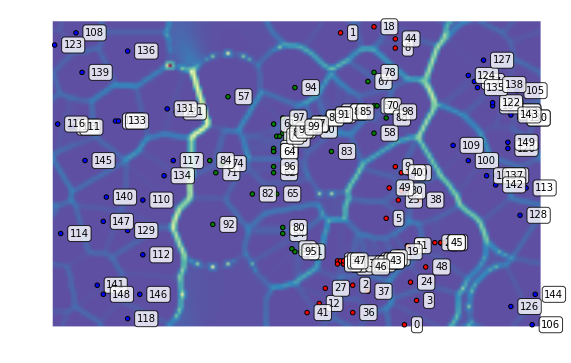

In [30]:
som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels)
som.update_data(updated_data)
som.train(epochs=2, radius0=20, scale0=0.02)
som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels)

As a result of the shift, the blue points do not move around much. On the other hand, the relationship of the red and green clusters is being redefined as their coordinates inched closer in the original space.